http://pyro.ai/examples/gp.html

In [1]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

In [2]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

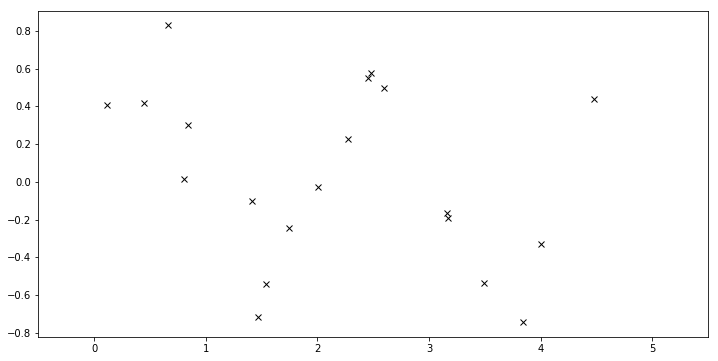

In [3]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [5]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.), lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

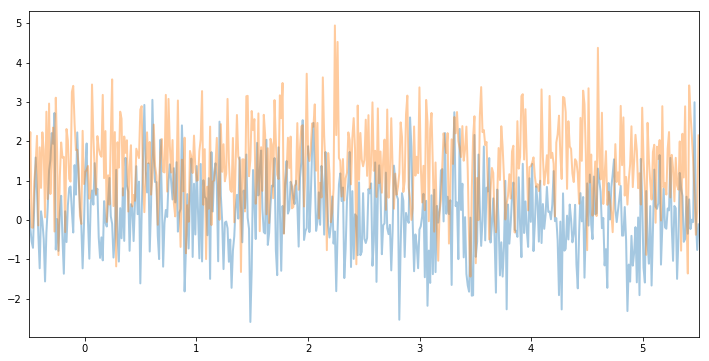

In [6]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)

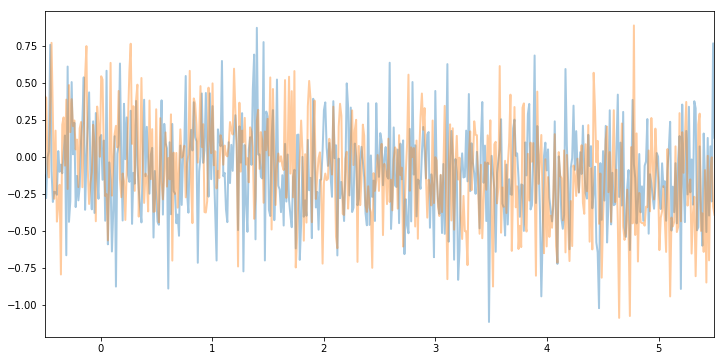

In [8]:
kernel2 = gp.kernels.RBF(input_dim=1, variance=torch.tensor(0.1), lengthscale=torch.tensor(10.))
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)

## Inference

In [9]:
optim = Adam({"lr": 0.005})
svi = SVI(gpr.model, gpr.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())

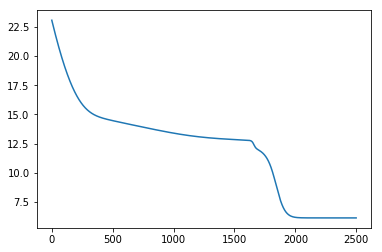

In [10]:
plt.plot(losses)

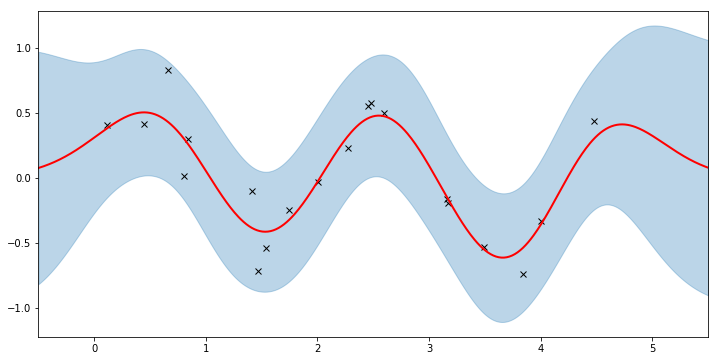

In [11]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [12]:
gpr.kernel.get_param("variance").item()

0.20291292667388916

In [13]:
gpr.kernel.get_param("lengthscale").item()

0.5022148489952087

In [14]:
gpr.get_param("noise").item()

0.04273039847612381

## Fit the model using MAP

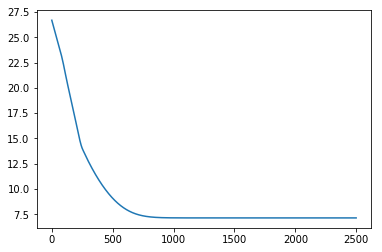

In [15]:
gpr.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 1.0))
gpr.kernel.set_prior("variance", dist.LogNormal(0.0, 1.0))
# we reset the param store so that the previous inference doesn't interfere with this one
pyro.clear_param_store()
optim = Adam({"lr": 0.005})
svi = SVI(gpr.model, gpr.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
plt.plot(losses);

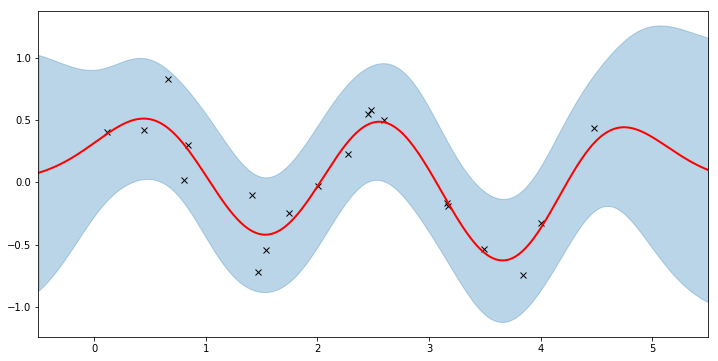

In [16]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [17]:
for param_name in pyro.get_param_store().get_all_param_names():
    print('{} = {}'.format(param_name, pyro.param(param_name).item()))

RBF$$$variance_MAP = 0.24471358954906464
RBF$$$lengthscale_MAP = 0.5217676758766174
GPR$$$noise = 0.04222387820482254


## Sparse GPs

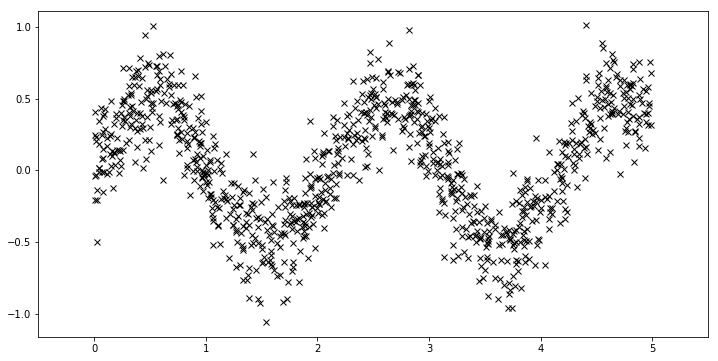

In [18]:
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

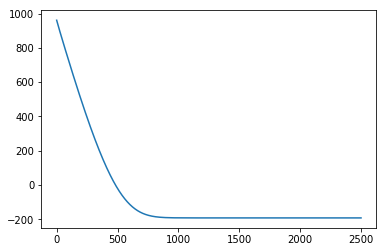

In [19]:
# initialize the inducing inputs
Xu = torch.arange(20) / 4.0

# initialize the kernel and model
kernel = gp.kernels.RBF(input_dim=1)
# we increase the jitter for better numerical stability
sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-5)

# the way we setup inference is similar to above
pyro.clear_param_store()
optim = Adam({"lr": 0.005})
svi = SVI(sgpr.model, sgpr.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
plt.plot(losses);

inducing points:
[ 0.02629729  0.22518663  0.50013447  0.65090799  0.95493174  1.01242006
  1.61101127  1.32074225  1.88348472  2.1645093   2.51020312  2.84303117
  3.06496525  3.36030221  3.69663906  3.92238903  4.23312521  4.57544184
  4.89587641  5.15466022]


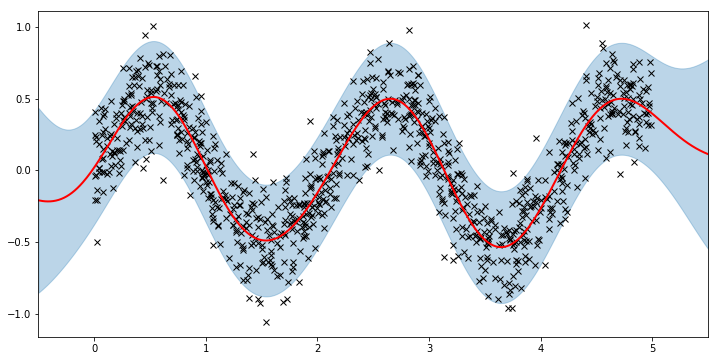

In [20]:
# let's look at the inducing points we've learned
print("inducing points:\n{}".format(pyro.param("SGPR$$$Xu").data.numpy()))
# and plot the predictions from the sparse GP
plot(model=sgpr, plot_observed_data=True, plot_predictions=True)